In [1]:
from cil.optimisation.functions import Function
from cil.framework import ImageGeometry, AcquisitionGeometry
import numpy                       
import matplotlib.pyplot as plt

from cil.optimisation.algorithms import PDHG, FISTA
from cil.optimisation.operators import GradientOperator, IdentityOperator, BlockOperator
from cil.optimisation.functions import KullbackLeibler, TotalVariation, BlockFunction, IndicatorBox, OperatorCompositionFunction, L2NormSquared, MixedL21Norm
from cil.plugins.ccpi_regularisation.functions import FGP_TV                      
from cil.plugins.astra.operators import ProjectionOperator
from cil.utilities.display import plotter2D
from cil.utilities.dataexample import TestData
from SmoothKullbackLeibler import SmoothKullbackLeibler
import os, sys
import tomophantom
from tomophantom import TomoP2D

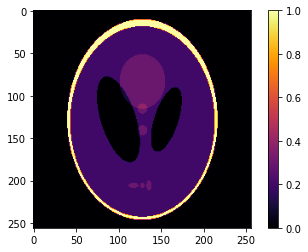

In [2]:
model = 1 # select a model number from the library
N = 256 # set dimension of the phantom
path = os.path.dirname(tomophantom.__file__)
path_library2D = os.path.join(path, "Phantom2DLibrary.dat")

phantom2D = TomoP2D.Model(model, N, path_library2D)    
ig = ImageGeometry(voxel_num_x=N, voxel_num_y=N)

shepp = ig.allocate()
shepp.fill(phantom2D)

plt.figure()
plt.imshow(shepp.as_array(), cmap="inferno")
plt.colorbar()
plt.show()

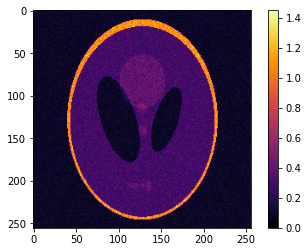

In [3]:
shepp_data = ig.allocate()
shepp_data.fill(phantom2D)

eta = ig.allocate()
eta.fill(0.1)
scale = 100
noisy_shepp_data = ig.allocate()
noisy_shepp_data.fill(numpy.random.poisson((phantom2D + eta.as_array())*scale)/scale)
# noisy_shepp_data.fill(numpy.random.poisson(phantom2D*scale))/scale + eta

plt.figure()
plt.imshow(noisy_shepp_data.as_array(), cmap="inferno")
plt.colorbar()
plt.show()  

In [8]:
KLfidelity = L2NormSquared(b = noisy_shepp_data, eta = eta)

alpha = 0.1

In [9]:
r_iterations = 100
r_tolerance = 1e-7          
r_iso = 1
r_nonneg = 1
r_printing = 0

#%% Setup total-variation (TV)
# TV = FGP_TV(alpha, r_iterations, r_tolerance, r_iso, r_nonneg, r_printing, 'gpu')
TV = alpha * TotalVariation(r_iterations, r_tolerance, lower = 0)

#%% Setup FISTA to solve for TV
fista_TV = FISTA(x_init=ig.allocate(0), f=KLfidelity, g=TV, 
                 max_iteration=100, update_objective_interval = 10)

#%% Run FISTA
fista_TV.run(verbose=1)

FISTA setting up
FISTA configured
     Iter   Max Iter     Time/Iter            Objective
                               [s]                     
Initialised GradientOperator with C backend running with  20  threads
        0        100         0.173          6.47026e+03
       10        100         0.164          2.75681e+02
       20        100         0.165          2.75681e+02
       30        100         0.161          2.75681e+02
       40        100         0.160          2.75681e+02
       50        100         0.160          2.75681e+02
       60        100         0.160          2.75681e+02
       70        100         0.164          2.75681e+02
       80        100         0.166          2.75681e+02
       90        100         0.167          2.75681e+02
      100        100         0.165          2.75681e+02
-------------------------------------------------------
      100        100         0.165          2.75681e+02
Stop criterion has been reached.



In [10]:
from cil.optimisation.algorithms import Algorithm
from cil.optimisation.functions import ZeroFunction
import numpy
import warnings

class FISTA_backtracking(Algorithm):

    
    def __init__(self, initial=None, f=None, g=ZeroFunction(), **kwargs):
                
        super(FISTA_backtracking, self).__init__(**kwargs)
        if kwargs.get('x_init', None) is not None:
            if initial is None:
                warnings.warn('The use of the x_init parameter is deprecated and will be removed in following version. Use initial instead',
                   DeprecationWarning, stacklevel=4)
                initial = kwargs.get('x_init', None)
            else:
                raise ValueError('{} received both initial and the deprecated x_init parameter. It is not clear which one we should use.'\
                    .format(self.__class__.__name__))
        
        if initial is not None and f is not None:
            self.set_up(initial=initial, f=f, g=g)

    def set_up(self, initial, f, g=ZeroFunction()):

        print("{} setting up".format(self.__class__.__name__, ))
        
        self.y = initial.copy()
        self.x_old = initial.copy()
        self.x = initial.copy()
        self.u = initial.copy()

        self.f = f
        self.g = g
        if f.L is None:
            raise ValueError('Error: Fidelity Function\'s Lipschitz constant is set to None')
        self.invL = 1/f.L
        self.t = 1
        self.configured = True
        print("{} configured".format(self.__class__.__name__, ))

            
    def update(self):
        
        Lbar = self.f.L
        backtrack = 1
        while backtrack:
            
            self.g.proximal(self.u, self.invL, out=self.x)
            
#             self.invL_bar = 1/Lbar
            
            F = self.f(self.x_old)
            Q = self.f(self.y) + (self.x_old - self.y).dot(self.f.gradient(self.y)) + Lbar/2 * ((self.x_old - self.y)**2).sum()
#             print(F, Q)
            
            
#        f = self.obfn_f(self.var_x())
#             Dxy = self.eval_Dxy()
#             Q = self.obfn_f(self.var_y()) + \
#                 self.eval_linear_approx(Dxy, gradY) + \
#                 (self.L / 2.) * np.linalg.norm(Dxy.flatten(), 2)**2            
            
            if F<=Q:
                backtrack = 0
            else:    
                Lbar*=10
# #             print(Lbar)
#             L = Lbar
# #             print(L)
            self.invL = 1/Lbar
    

        print(self.invL)
        self.t_old = self.t
        self.f.gradient(self.y, out=self.u)
        self.u.__imul__( -self.invL )
        self.u.__iadd__( self.y )

        self.g.proximal(self.u, self.invL, out=self.x)
        
        self.t = 0.5*(1 + numpy.sqrt(1 + 4*(self.t_old**2)))
        
        self.x.subtract(self.x_old, out=self.y)
        self.y.axpby(((self.t_old-1)/self.t), 1, self.x, out=self.y)
        
        self.x_old.fill(self.x)

        
    def update_objective(self):
        self.loss.append( self.f(self.x) + self.g(self.x) )    
    


In [11]:
#%% Setup FISTA to solve for TV
fista_TV_back = FISTA_backtracking(x_init=ig.allocate(0), f=KLfidelity, g=TV, 
                 max_iteration=100, update_objective_interval = 10)

#%% Run FISTA
fista_TV_back.run(verbose=1)

FISTA_backtracking setting up
FISTA_backtracking configured
     Iter   Max Iter     Time/Iter            Objective
                               [s]                     
0.5


/opt/anaconda3/envs/CIL2_submit/lib/python3.7/site-packages/cil/optimisation/functions/TotalVariation.py:190: RuntimeWarning: invalid value encountered in float_scalars
  error /= p1.norm()


        0        100         0.334          6.47026e+03
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
       10        100         0.317          2.75681e+02
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
       20        100         0.327          2.75681e+02
0.5
5e-07
0.5
0.5
0.5
0.5
0.5
0.5
0.5
5e-07
       30        100         0.409          2.75681e+02
0.5
0.5
5e-07
0.5
0.5
0.5
0.5
5e-07
0.5
5e-06
       40        100         0.460          2.75681e+02
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
5e-07
       50        100         0.456          2.75681e+02
0.5
0.5
5e-07
0.5
0.5
5e-07
0.5
0.5
0.5
5e-07
       60        100         0.473          2.75681e+02
0.5
0.5
5e-07
0.5
5e-06
0.5
0.5
0.5
5e-07
5e-06
       70        100         0.492          2.75680e+02
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
       80        100         0.469          2.75681e+02
5e-07
0.5
0.5
5e-07
0.5
0.5
0.5
0.5
0.5
5e-07
       90        100         0.481          2.75681e+02
0.5
5e-06
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
      

In [ ]:
8.66876e+03
       10        100         0.172          1.45546e+03
       20        100         0.178          5.54311e+02
       30        100         0.180          4.49635e+02
       40        100         0.185          4.36164e+02
       50        100         0.185          4.39850e+02
       60        100         0.186          4.37647e+02
       70        100         0.184          4.34770e+02
       80        100         0.186          4.34378e+02
       90        100         0.188          4.34911e+02
      100        100         0.189          4.34638e+02
-------------------------------------------------------
      100        100         0.189          4.34638e+02